#CS 412 TERM PROJECT


Group Members:<br><br>
Cem Kaya<br>
Selin Tokman<br>
Uğur Kağan Çakır

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive/') 


Mounted at /content/drive/


In [ ]:
#cd drive/My\ Drive/Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


##Importing libraries needed

In [1]:
# import the necessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
import scipy.io as sio
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import keras
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Flatten, Dense
from keras.models import Model, load_model
#% matplotlib inline
import cv2 as cv
from sklearn.model_selection import train_test_split
import os
import pickle

import tensorflow  as tf
tf.config.list_physical_devices() # check local GPU (CEM)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

##Loading Test and Training Data

In [2]:
train_data = sio.loadmat('train_32x32.mat')
test_data = sio.loadmat('testimgs_32x32.mat')

# access to the dict
all_images = np.array(train_data['X'] )
all_labels = np.array(train_data['y'] )

all_test_images = np.array(test_data['X'] )

# show sample


#print( all_labels[image_ind] ) 
print( "shape of all_images before fixing axes: " , all_images.shape )
#fix file formet ?why .mat google ????
all_test_images_fix = np.moveaxis(all_test_images, -1, 0) #MAGIC 2

all_images_fixed = np.moveaxis(all_images, -1, 0) #MAGIC 
print( "shape of all_images_fixed: " , all_images_fixed.shape )
print("shape of labels: ", all_labels.shape)

print( "shape of all_test_images_fixed: " , all_test_images_fix.shape )
#print(test_data)

shape of all_images before fixing axes:  (32, 32, 3, 73257)
shape of all_images_fixed:  (73257, 32, 32, 3)
shape of labels:  (73257, 1)
shape of all_test_images_fixed:  (26032, 32, 32, 3)


##Preprocessing


###We added more data by rotating our existing images, in order to our models to learn more

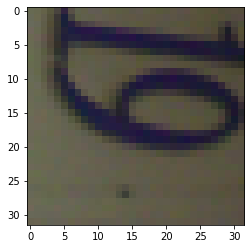

In [3]:
#np.rot90()
rotated_images = np.flip(all_images_fixed.swapaxes(1,2), axis = 2)
rotated_images2 = np.flip(rotated_images.swapaxes(1,2), axis = 2)
rotated_images3 = np.flip(rotated_images2.swapaxes(1,2), axis = 2)
# Too much rotation 

plt.imshow(rotated_images[1])
plt.show()

####We rotated our models by 90, 180, and 270 degrees<br>Then added all images in a different numpy array called all_images_fixed_and_rotated

In [4]:
print("all_images_fixed" ,all_images_fixed.shape )
print("rotated_images" ,rotated_images.shape )
print("rotated_images2" ,rotated_images2.shape )
print("rotated_images3" ,rotated_images3.shape )

#aa = np.zeros(rotated_images.shape, rotated_images.dtype)

#all_images_fixed = all_images_fixed + rotated_images

tmp=[]
for i in  all_images_fixed:
    tmp.append(i)
for i in  rotated_images:
    tmp.append(i)
for i in  rotated_images2:
    tmp.append(i)
for i in  rotated_images3:
    tmp.append(i)
all_images_fixed_and_rotated = np.array(tmp)
print("all_images_fixed_and_rotated" ,all_images_fixed_and_rotated.shape )

all_images_fixed (73257, 32, 32, 3)
rotated_images (73257, 32, 32, 3)
rotated_images2 (73257, 32, 32, 3)
rotated_images3 (73257, 32, 32, 3)
all_images_fixed_and_rotated (293028, 32, 32, 3)


##Using thresholding to enhance image quality

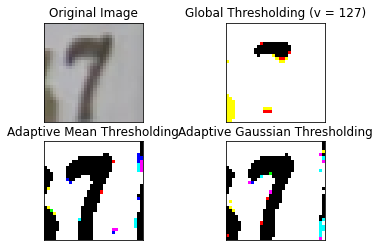

<Figure size 432x288 with 0 Axes>

In [5]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.144]).astype('uint8')
def r2gray(rgb):
    return cv.split(rgb)
     
def gray2rgb(r,g,b):
    return cv.merge([r,g,b])
    
#pre processing 
#wrong data type or memory layout !!!!!!!!!!!!!!!!!!!
img_b, img_g, img_r = r2gray(all_images_fixed_and_rotated[11024])

img_b = cv.medianBlur(img_b,5)
ret_b,th1_b = cv.threshold(img_b,90 ,255,cv.THRESH_BINARY)
th2_b = cv.adaptiveThreshold(img_b,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,11,2)      #nparray.dtype == uint8 & grayscale image
th3_b = cv.adaptiveThreshold(img_b,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)

img_g = cv.medianBlur(img_g,5)
ret_g, th1_g = cv.threshold(img_g,90 ,255,cv.THRESH_BINARY)
th2_g = cv.adaptiveThreshold(img_g,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,11,2)      #nparray.dtype == uint8 & grayscale image
th3_g = cv.adaptiveThreshold(img_g,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)

img_r = cv.medianBlur(img_r,5)
ret_r, th1_r = cv.threshold(img_r,90 ,255,cv.THRESH_BINARY)
th2_r = cv.adaptiveThreshold(img_r,255,cv.ADAPTIVE_THRESH_MEAN_C, cv.THRESH_BINARY,11,2)      
th3_r = cv.adaptiveThreshold(img_r,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)    #nparray.dtype == uint8 & grayscale image

th1= gray2rgb(th1_b,th1_g,th1_r)
th2= gray2rgb(th2_b,th2_g,th2_r)
th3= gray2rgb(th3_b,th3_g,th3_r)

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [all_images_fixed_and_rotated[11024], th1, th2, th3]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray');
    plt.title(titles[i]);
    plt.xticks([]),plt.yticks([]);
plt.show();
plt.savefig(fname="a");

####Our cleaned images had the correct size

In [6]:
print(th3.shape)

(32, 32, 3)


####Image cleaning function

In [8]:
def img_clean(img):
    img_b, img_g, img_r = r2gray(img)

    img_b = cv.medianBlur(img_b,5)
    th_b = cv.adaptiveThreshold(img_b,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)

    img_g = cv.medianBlur(img_g,5)
    th_g = cv.adaptiveThreshold(img_g,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)

    img_r = cv.medianBlur(img_r,5)
    th_r = cv.adaptiveThreshold(img_r,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,2)    #nparray.dtype == uint8 & grayscale image

    return gray2rgb(th_b,th_g,th_r)

   

####An example of an image after it gets cleaned:

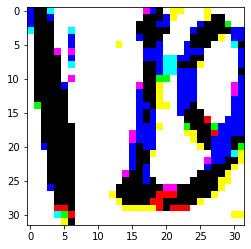

In [9]:
plt.imshow(img_clean(all_images_fixed[0]))
plt.show()

####Normal image:

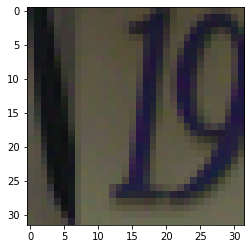

In [10]:
plt.imshow(all_images_fixed[0])
plt.show()

####We apply image cleaning to both test and training data & store resulting arrays in seperate numpy arrays

In [11]:
tmp=[]
for i in all_test_images_fix:
    tmp.append( img_clean(i))
all_test_images_fix2 = tmp
all_test_images_fix2 = np.array(all_test_images_fix2)

In [12]:
tmp=[]
for i in all_images_fixed:
    tmp.append( img_clean(i))
all_images_fixed2 = tmp
all_images_fixed2=np.array(all_images_fixed2)

In [13]:
all_images_fixed2.shape

(73257, 32, 32, 3)

####Adding One Hot Encoding for our labels

In [14]:
# One HOT encode
print(all_labels)
all_labels_fixed=[]
for label in all_labels:
    tmp=[0]*10    
    label_num = label[0]
    label_num = label_num if  label_num < 10 else 0
    tmp[label_num  ]=1
    all_labels_fixed.append(   tmp  )

all_labels_fixed = np.array(all_labels_fixed)
print(all_labels_fixed[2])

[[1]
 [9]
 [2]
 ...
 [1]
 [6]
 [9]]
[0 0 1 0 0 0 0 0 0 0]


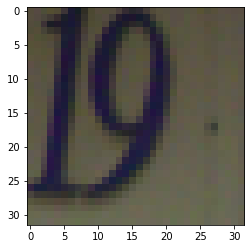

In [15]:
plt.imshow(all_images_fixed[1,:,:,:])
plt.show()

####Adjusting the labels for the rotated images

In [16]:
tmp=[]
for i in range(4):
    for j in all_labels_fixed:
        tmp.append(j)
all_labels_fixed2_and_rotated = np.array(tmp)        

In [17]:
all_labels_fixed2_and_rotated.shape

(293028, 10)

##Model Training

###Splitting training and validation data

In [18]:
x_train,x_val,y_train,y_val = train_test_split(  all_images_fixed , all_labels_fixed ,test_size=0.1,random_state=42)
x_train2,x_val2,y_train2,y_val2 = train_test_split(  all_images_fixed2 , all_labels_fixed  ,test_size=0.1,random_state=42)
x_train3,x_val3,y_train3,y_val3 = train_test_split(  all_images_fixed_and_rotated , all_labels_fixed2_and_rotated  ,test_size=0.1,random_state=42)
print("x_train.shape:",x_train.shape)
print("x_train2.shape:",x_train2.shape)
print("x_train3.shape:",x_train3.shape)

x_train.shape: (65931, 32, 32, 3)
x_train2.shape: (65931, 32, 32, 3)
x_train3.shape: (263725, 32, 32, 3)


###VGG16

In [19]:
augmenter = ImageDataGenerator(rotation_range=12 ,   zoom_range=[0.90, 1.10], height_shift_range=0.25,  shear_range=0.15)

In [20]:
# Train your own model with your own choice of parameters, and pretrained model 
img_shape_sv =  (32, 32, 3)
print("VGG 16 ")
print(img_shape_sv)
model_vgg_conv = VGG16(weights='imagenet', include_top=False, input_shape=img_shape_sv  )
#model_vgg_conv.summary()
for layer in model_vgg_conv.layers:
   layer.trainable = True
 

#Create your own input format
keras_input = Input(shape=img_shape_sv, name = 'image_input')

#Use the generated model
output_vgg_conv = model_vgg_conv(keras_input)

# Add 3 fully-connected layers 
My_vgg = Flatten(name='flatten')(output_vgg_conv)
My_vgg = Dense(512 , activation='relu', name='fc0')(My_vgg)
My_vgg = Dense(128 , activation='relu', name='fc2')(My_vgg)
My_vgg = Dense(64 ,activation='relu', name='fc3')(My_vgg)
My_vgg = Dense(10, activation='softmax' , name='predictions')(My_vgg)

VGG 16 
(32, 32, 3)


###We trained our model with the normal, thresholded, and rotated images

####On normal images

In [21]:
#Create your own modelg
pretrained_model1 = Model(inputs=keras_input, outputs=My_vgg)
pretrained_model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', "categorical_crossentropy" ])

# Train the model using own data  x_train,x_val,y_train,y_val 
#history1 = pretrained_model1.fit(x_train, y_train  ,batch_size=64 , epochs=16 ,validation_split = 0.125 )
H = pretrained_model1.fit(augmenter.flow(x_train, y_train, batch_size=64),validation_data=(x_val, y_val), steps_per_epoch=len(x_train) // 64, epochs=20)

# Evaluate the model
score = pretrained_model1.evaluate(x_val, y_val)
print("Accuracy on val set: ", score[1])

# save the model to disk
filename = 'pretrained_model1.sav'
#pickle.dump(pretrained_model1, open(filename, 'wb'))

Epoch 1/20
1030/1030 [==============================] - 45s 42ms/step - loss: 2.2656 - accuracy: 0.1868 - categorical_crossentropy: 2.2656 - val_loss: 2.2400 - val_accuracy: 0.1994 - val_categorical_crossentropy: 2.2400
Epoch 2/20
1030/1030 [==============================] - 40s 38ms/step - loss: 1.7035 - accuracy: 0.4030 - categorical_crossentropy: 1.7035 - val_loss: 0.8665 - val_accuracy: 0.7472 - val_categorical_crossentropy: 0.8665
Epoch 3/20
1030/1030 [==============================] - 39s 37ms/step - loss: 0.7228 - accuracy: 0.7886 - categorical_crossentropy: 0.7228 - val_loss: 0.5074 - val_accuracy: 0.8561 - val_categorical_crossentropy: 0.5074
Epoch 4/20
1030/1030 [==============================] - 39s 38ms/step - loss: 0.5169 - accuracy: 0.8534 - categorical_crossentropy: 0.5169 - val_loss: 0.4534 - val_accuracy: 0.8666 - val_categorical_crossentropy: 0.4534
Epoch 5/20
1030/1030 [==============================] - 40s 38ms/step - loss: 0.4575 - accuracy: 0.8717 - categorical_cr

#####Tested accuracy on both normal and thresholded images. Since we can also threshold test images without knowing their labels beforehand.

In [ ]:
pretrained_model1 = pickle.load(open('pretrained_model1.sav', 'rb'))
score = pretrained_model1.evaluate(x_val2, y_val2)
print("Accuracy on val set that is thresholded: ", score[1])

229/229 [==============================] - 5s 21ms/step - loss: 1.0391 - accuracy: 0.7518 - categorical_crossentropy: 1.0391
Accuracy on val set that is thresholded:  0.751842737197876


####On thresholded images

In [ ]:
#Create your own modelg
pretrained_model1_2 = Model(inputs=keras_input, outputs=My_vgg)
pretrained_model1_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', "categorical_crossentropy" ])

# Train the model using own data  x_train2,x_val2,y_train2,y_val2 
history1 = pretrained_model1_2.fit(x_train2, y_train2  ,batch_size=64 , epochs=16 ,validation_split = 0.125 )

# Evaluate the model
score = pretrained_model1_2.evaluate(x_val2, y_val2)
print("Accuracy on val set: ", score[1])

# save the model to disk
filename = 'pretrained_model1_2.sav'
pickle.dump(pretrained_model1_2, open(filename, 'wb'))

Epoch 1/16
902/902 [==============================] - 75s 82ms/step - loss: 0.5481 - accuracy: 0.8487 - categorical_crossentropy: 0.5481 - val_loss: 0.5544 - val_accuracy: 0.8556 - val_categorical_crossentropy: 0.5544
Epoch 2/16
902/902 [==============================] - 73s 81ms/step - loss: 0.4671 - accuracy: 0.8732 - categorical_crossentropy: 0.4671 - val_loss: 1.2311 - val_accuracy: 0.7895 - val_categorical_crossentropy: 1.2311
Epoch 3/16
902/902 [==============================] - 73s 81ms/step - loss: 0.5187 - accuracy: 0.8590 - categorical_crossentropy: 0.5187 - val_loss: 0.4767 - val_accuracy: 0.8726 - val_categorical_crossentropy: 0.4767
Epoch 4/16
902/902 [==============================] - 74s 82ms/step - loss: 0.3596 - accuracy: 0.9013 - categorical_crossentropy: 0.3596 - val_loss: 0.4622 - val_accuracy: 0.8806 - val_categorical_crossentropy: 0.4622
Epoch 5/16
902/902 [==============================] - 74s 82ms/step - loss: 0.3235 - accuracy: 0.9117 - categorical_crossentropy

#####Same approach here

In [ ]:
pretrained_model1_2 = pickle.load(open('pretrained_model1_2.sav', 'rb'))
score = pretrained_model1_2.evaluate(x_val, y_val)
print("Accuracy on the normal val set: ", score[1])

229/229 [==============================] - 5s 21ms/step - loss: 1.1142 - accuracy: 0.6308 - categorical_crossentropy: 1.1142
Accuracy on the normal val set:  0.6307671070098877


####On rotated images

In [ ]:
pretrained_model1_3 = Model(inputs=keras_input, outputs=My_vgg)
pretrained_model1_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', "categorical_crossentropy" ])

# Train the model using own data  x_train,x_val,y_train,y_val 
history1 = pretrained_model1_3.fit(x_train3, y_train3  ,batch_size=64 , epochs=16 ,validation_split = 0.125 )

# Evaluate the model
score = pretrained_model1_3.evaluate(x_val3, y_val3)
print("Accuracy on val set: ", score[1])

# save the model to disk
filename = 'pretrained_model1_3.sav'
pickle.dump(pretrained_model1_3, open(filename, 'wb'))

Epoch 1/16
3606/3606 [==============================] - 305s 84ms/step - loss: 1.2832 - accuracy: 0.5434 - categorical_crossentropy: 1.2832 - val_loss: 0.6518 - val_accuracy: 0.7739 - val_categorical_crossentropy: 0.6518
Epoch 2/16
3606/3606 [==============================] - 300s 83ms/step - loss: 0.5691 - accuracy: 0.8042 - categorical_crossentropy: 0.5691 - val_loss: 0.5265 - val_accuracy: 0.8184 - val_categorical_crossentropy: 0.5265
Epoch 3/16
3606/3606 [==============================] - 308s 86ms/step - loss: 0.4951 - accuracy: 0.8279 - categorical_crossentropy: 0.4951 - val_loss: 0.4984 - val_accuracy: 0.8283 - val_categorical_crossentropy: 0.4984
Epoch 4/16
3606/3606 [==============================] - 300s 83ms/step - loss: 0.4611 - accuracy: 0.8394 - categorical_crossentropy: 0.4611 - val_loss: 0.4780 - val_accuracy: 0.8347 - val_categorical_crossentropy: 0.4780
Epoch 5/16
3606/3606 [==============================] - 300s 83ms/step - loss: 0.4405 - accuracy: 0.8463 - categoric

In [ ]:
pretrained_model1_3 = pickle.load(open('pretrained_model1_3.sav', 'rb'))
score = pretrained_model1_3.evaluate(x_val, y_val)
print("Accuracy on the normal val set: ", score[1])

229/229 [==============================] - 5s 20ms/step - loss: 2.2240 - accuracy: 0.1994 - categorical_crossentropy: 2.2240
Accuracy on the normal val set:  0.19942669570446014


In [ ]:
pretrained_model1_3 = pickle.load(open('pretrained_model1_3.sav', 'rb'))
score = pretrained_model1_3.evaluate(x_val2, y_val2)
print("Accuracy on the thresholded val set: ", score[1])

229/229 [==============================] - 5s 20ms/step - loss: 2.2240 - accuracy: 0.1994 - categorical_crossentropy: 2.2240
Accuracy on the thresholded val set:  0.19942669570446014


####The model that is trained with the thresholded images gave the best result on training data. However, that model failed to get good accuracy results both on the normal and the thresholded validation data. The validation accuracy was better for the model that fitted on the normal images. The model that fitted on the thresholded images has overfitted to the training data.

###VGG19

In [23]:
# Train your own model with your own choice of parameters, and pretrained model 

img_shape_sv =  (32, 32, 3)

print(img_shape_sv)
model_vgg_19 =tf.keras.applications.VGG19( weights='imagenet', include_top=False, input_shape=img_shape_sv  )
#model_vgg_conv.summary()
for layer in model_vgg_19.layers:
  layer.trainable = True


#Create your own input format
keras_input = Input(shape=img_shape_sv, name = 'image_input')

#Use the generated model
output_vgg_conv19 = model_vgg_19(keras_input)

# Add 3 fully-connected layers 
My_vgg = Flatten(name='flatten')(output_vgg_conv19)
My_vgg = Dense(512 , activation='relu', name='fc0')(My_vgg)
My_vgg = Dense(128 , activation='relu', name='fc1')(My_vgg)
My_vgg = Dense(64 ,activation='relu', name='fc2')(My_vgg)
My_vgg = Dense(10, activation='softmax' , name='predictions')(My_vgg)

#Create your own modelg
pretrained_model2 = Model(inputs=keras_input, outputs=My_vgg)
pretrained_model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', "categorical_crossentropy" ])

# Train the model using own data  x_train,x_val,y_train,y_val 
#history = pretrained_model2.fit(x_train, y_train  ,batch_size=128 , epochs=16 ,validation_split = 0.125 )
H = pretrained_model2.fit(augmenter.flow(x_train, y_train, batch_size=128),validation_data=(x_val, y_val), steps_per_epoch=len(x_train) // 128, epochs=20)

# Evaluate the model
score = pretrained_model2.evaluate(x_val, y_val)
print("Accuracy on val set: ", score[1])

# save the model to disk
filename = 'pretrained_model2.sav'
#pickle.dump(pretrained_model2, open(filename, 'wb'))

(32, 32, 3)
Epoch 1/20
515/515 [==============================] - 39s 71ms/step - loss: 2.1024 - accuracy: 0.2512 - categorical_crossentropy: 2.1024 - val_loss: 1.5695 - val_accuracy: 0.4302 - val_categorical_crossentropy: 1.5695
Epoch 2/20
515/515 [==============================] - 37s 72ms/step - loss: 1.3749 - accuracy: 0.4990 - categorical_crossentropy: 1.3749 - val_loss: 0.8456 - val_accuracy: 0.7098 - val_categorical_crossentropy: 0.8456
Epoch 3/20
515/515 [==============================] - 37s 72ms/step - loss: 0.8155 - accuracy: 0.7418 - categorical_crossentropy: 0.8155 - val_loss: 0.4945 - val_accuracy: 0.8619 - val_categorical_crossentropy: 0.4945
Epoch 4/20
515/515 [==============================] - 38s 74ms/step - loss: 0.5302 - accuracy: 0.8511 - categorical_crossentropy: 0.5302 - val_loss: 0.3841 - val_accuracy: 0.8946 - val_categorical_crossentropy: 0.3841
Epoch 5/20
515/515 [==============================] - 37s 71ms/step - loss: 0.4901 - accuracy: 0.8650 - categorical_

###ResNet

In [25]:
# Train your own model with your own choice of parameters, and pretrained model 
img_shape =  (32, 32, 3)

print(img_shape_sv)
model_ResNet = tf.keras.applications.ResNet101(    include_top=False,    weights="imagenet",
    input_tensor=None,
    input_shape=img_shape,
    pooling=None, 
)
#model_vgg_conv.summary()
for layer in model_ResNet.layers:
  layer.trainable = True


#Create your own input format
keras_input = Input(shape=img_shape, name = 'image_input')

#Use the generated model
output_ResNet = model_ResNet(keras_input)

# Add 3 fully-connected layers 
My_vgg = Flatten(name='flatten')(output_ResNet)
My_vgg = Dense(1024 , activation='relu', name='fc0')(My_vgg)
My_vgg = Dense(512 , activation='relu', name='fc1')(My_vgg)
My_vgg = Dense(128 ,activation='relu', name='fc2')(My_vgg)
My_vgg = Dense(10, activation='softmax' , name='predictions')(My_vgg)

#Create your own modelg
pretrained_model3 = Model(inputs=keras_input, outputs=My_vgg)
pretrained_model3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', "categorical_crossentropy" ])

# Train the model using own data  x_train,x_val,y_train,y_val 
#history = pretrained_model3.fit(x_train, y_train, batch_size=128, epochs=16 , validation_split = 0.125 )
H = pretrained_model3.fit(augmenter.flow(x_train, y_train, batch_size=256),validation_data=(x_val, y_val), steps_per_epoch=len(x_train) // 256, epochs=20)

# Evaluate the model
score = pretrained_model3.evaluate(x_val, y_val)
print("Accuracy on val set: ", score[1])

# save the model to disk
filename = 'pretrained_model3.sav'
#pickle.dump(pretrained_model3, open(filename, 'wb'))

(32, 32, 3)
Epoch 1/20
257/257 [==============================] - 67s 229ms/step - loss: 1.0679 - accuracy: 0.6494 - categorical_crossentropy: 1.0679 - val_loss: 1.0010 - val_accuracy: 0.7536 - val_categorical_crossentropy: 1.0010
Epoch 2/20
257/257 [==============================] - 57s 221ms/step - loss: 0.4620 - accuracy: 0.8613 - categorical_crossentropy: 0.4620 - val_loss: 0.9492 - val_accuracy: 0.7546 - val_categorical_crossentropy: 0.9492
Epoch 3/20
257/257 [==============================] - 57s 220ms/step - loss: 0.3840 - accuracy: 0.8857 - categorical_crossentropy: 0.3840 - val_loss: 0.5914 - val_accuracy: 0.8191 - val_categorical_crossentropy: 0.5914
Epoch 4/20
257/257 [==============================] - 56s 218ms/step - loss: 0.3525 - accuracy: 0.8953 - categorical_crossentropy: 0.3525 - val_loss: 0.3596 - val_accuracy: 0.8933 - val_categorical_crossentropy: 0.3596
Epoch 5/20
257/257 [==============================] - 55s 212ms/step - loss: 0.3184 - accuracy: 0.9068 - categor

##Predictions

In [ ]:
# load the model from disk
#pretrained_model1 = pickle.load(open('pretrained_model1.sav', 'rb'))
#pretrained_model2 = pickle.load(open('pretrained_model2.sav', 'rb'))
#pretrained_model3 = pickle.load(open('pretrained_model3.sav', 'rb'))

In [26]:
predictions_1 = pretrained_model1.predict(all_test_images_fix)

In [27]:
predictions_2 = pretrained_model2.predict(all_test_images_fix)

In [28]:
predictions_3 = pretrained_model3.predict(all_test_images_fix)
print(predictions_3)

[[1.3745698e-03 9.7828973e-03 1.6577318e-02 ... 4.3624975e-03
  2.2610172e-03 6.5947175e-03]
 [2.2952561e-06 3.9539191e-05 9.9967170e-01 ... 2.1008170e-06
  9.1085340e-06 4.7562462e-05]
 [4.5765346e-04 9.9703217e-01 2.7410657e-04 ... 2.4489369e-04
  1.3820537e-04 1.0810900e-04]
 ...
 [1.3884521e-03 2.7587060e-03 6.4793434e-03 ... 9.8483723e-01
  1.0119583e-04 1.8814930e-03]
 [3.0086779e-03 2.1935666e-03 1.1521804e-03 ... 1.4440529e-04
  4.7564458e-02 5.1912013e-04]
 [8.3039032e-04 5.3910860e-03 1.7189187e-03 ... 9.8880577e-01
  6.5630513e-05 1.7356836e-03]]


##Ensemble/Blend

In [29]:
blend_pred=[]
for i,j,k in zip (predictions_1 , predictions_2 ,predictions_3):
    tmp_list=[]
    for x, y ,z in zip(i,j,k):
        tmp_list.append( x * y * z )
    blend_pred.append( tmp_list  )
#print(blend_pred)

##Write predictions to a file

In [30]:
prediction_subition_ensamble_string="Id,Prediction\n"
for S_id , prediction in enumerate(blend_pred):    
    prediction_subition_ensamble_string += str(S_id) +","+ ( "10"   if  str(np.argmax(prediction)) =="0" else str(np.argmax(prediction)) )  + "\n"


#print(prediction_subition_ensamble_string)

In [31]:
with open("SU_Group8_ens_final.csv","w") as file :
    file.write(prediction_subition_ensamble_string)

In [ ]:
prediction_subition_string="Id,Prediction\n"
for S_id , prediction in enumerate(predictions_1):    
    prediction_subition_string += str(S_id) +","+ ( "10"   if  str(np.argmax(prediction)) =="0" else str(np.argmax(prediction)) )  + "\n"


#print(prediction_subition_string)

In [ ]:
with open("SU_Group8_p2.csv","w") as file :
    file.write(prediction_subition_string)

###Decision Tree

In [ ]:
x_train_flat = x_train2.reshape(x_train2.shape[0],-1)
x_val_flat = x_val2.reshape(x_val2.shape[0],-1)

print(x_train_flat.shape)

(65931, 3072)


In [ ]:
# Train DT classifiers
from sklearn.tree import DecisionTreeClassifier
alldt={}
depth_list=[1,10,20,50,100]
split_list= [2,10,100,200,1000]
for depth in depth_list:  
    for split in split_list:
        alldt[(depth,split)] = DecisionTreeClassifier(max_depth=depth , min_samples_split=split ,random_state=42)

In [ ]:
#takes ~20minutes made this way because was curiouse about the performance 
for depth in depth_list:  
    for split in split_list:
        alldt[(depth,split)].fit(x_train_flat,y_train2)

In [ ]:
from sklearn.metrics import accuracy_score
accdict={}
for depth in depth_list:  
    for split in split_list:
        acc = accuracy_score( y_val2,alldt[(depth,split)].predict(x_val_flat) )
        print("The accuracy score of the dt with depth {} and split {} is:{}".format(depth,split,acc ) )    
        accdict[(depth,split)]=acc

The accuracy score of the dt with depth 1 and split 2 is:0.0
The accuracy score of the dt with depth 1 and split 10 is:0.0
The accuracy score of the dt with depth 1 and split 100 is:0.0
The accuracy score of the dt with depth 1 and split 200 is:0.0
The accuracy score of the dt with depth 1 and split 1000 is:0.0
The accuracy score of the dt with depth 10 and split 2 is:0.47652197652197653
The accuracy score of the dt with depth 10 and split 10 is:0.4761124761124761
The accuracy score of the dt with depth 10 and split 100 is:0.4477204477204477
The accuracy score of the dt with depth 10 and split 200 is:0.4107289107289107
The accuracy score of the dt with depth 10 and split 1000 is:0.27245427245427245
The accuracy score of the dt with depth 20 and split 2 is:0.5574665574665575
The accuracy score of the dt with depth 20 and split 10 is:0.5326235326235326
The accuracy score of the dt with depth 20 and split 100 is:0.4443079443079443
The accuracy score of the dt with depth 20 and split 200 i

###kNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
n_lıst=[1 , 2 , 3 , 5 , 7 , 25] 
knn_list=[]
for n in n_lıst:
    knn_list.append(KNeighborsClassifier(n_neighbors=n,algorithm="brute" ))

for m in knn_list:
    m.fit(x_train_flat,y_train2)

for i,m in zip(n_lıst ,knn_list ):
    acc= accuracy_score(y_val2,m.predict(x_val_flat) )
    print("The accuracy score of the knn with n={} is:{}".format( i,acc))

The accuracy score of the knn with n=1 is:0.6274911274911275
The accuracy score of the knn with n=2 is:0.46478296478296477
The accuracy score of the knn with n=3 is:0.5977340977340977
The accuracy score of the knn with n=5 is:0.5735735735735735
The accuracy score of the knn with n=7 is:0.5586950586950586
The accuracy score of the knn with n=25 is:0.47338247338247336


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
import sklearn
#dist = sklearn.metrics.DistanceMetric.get_metric('euclidean')
n_list=[1 , 3 , 20] 
knn_list2=[]
for n in n_list:
    knn_list2.append(KNeighborsClassifier(n_neighbors=n,algorithm="brute" ,metric="hamming" ))

for m in knn_list2:
    m.fit(x_train_flat,y_train2)

for i,m in zip(n_list ,knn_list2 ):
    acc= accuracy_score(y_val2,m.predict(x_val_flat) )
    print("The accuracy score of the knn with n={} is:{}".format( i,acc))

The accuracy score of the knn with n=1 is:0.6274911274911275
The accuracy score of the knn with n=3 is:0.5977340977340977
The accuracy score of the knn with n=20 is:0.4651924651924652
